In [165]:
import pandas as pd
import numpy as np
import Yield_Curve_Functions as ycf
import statsmodels.api as sm
from scipy.stats import norm
import yfinance as yf
import copulas
from copulas.multivariate import GaussianMultivariate
import matplotlib.pyplot as plt


R = 0.4 # Recovery Rate


In [166]:
# Load CDS from csv file
cds_data = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/cds.csv')

In [167]:
# Ticker with highest value in 10Y column
cds_data.loc[cds_data['PX10'].idxmax(), 'Company']

'Europcar'

In [168]:
cds_data['Company'].unique()


array(['Agilent Technologies Inc', 'Anglo American PLC', 'Apple Inc',
       'ABB Ltd', 'AbbVie Inc', 'AmerisourceBergen Corp',
       'Abertis Infraestructuras SA', 'Anheuser Busch InBev SA NV',
       'Abbott Laboratories', 'Barrick Gold Corp', 'Credit Agricole',
       'ACEA SpA', 'Accor SA', 'Adecco Group AG', 'ADLER Real Estate AG',
       'Archer-Daniels-Midland Co', 'Koninklijke Ahold Delhaize NV',
       'Automatic Data Processing Inc', 'adidas AG', 'Aegon NV',
       'The AES Corporation', 'Aetna Inc', 'American Financial Group Inc',
       'African Export-Import Bank', 'Avangrid Inc',
       'Agricultural Bank of China Ltd', 'Ageas', 'Air Liquide SA',
       'American International Group Inc', 'Airbus SE', 'Akzo Nobel NV',
       'Allstate Corp', 'Alliander NV', 'Ally Financial Inc', 'Alstom SA',
       'Alpha Bank AE', 'Allianz SE', 'Applied Materials Inc',
       'Amgen Inc', 'Ameriprise Financial Inc', 'American Tower Corp',
       'America Movil SAB de CV', 'Amazon.com In

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_25970/1483561134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_cds['Date'] = pd.to_datetime(apple_cds['Date'])


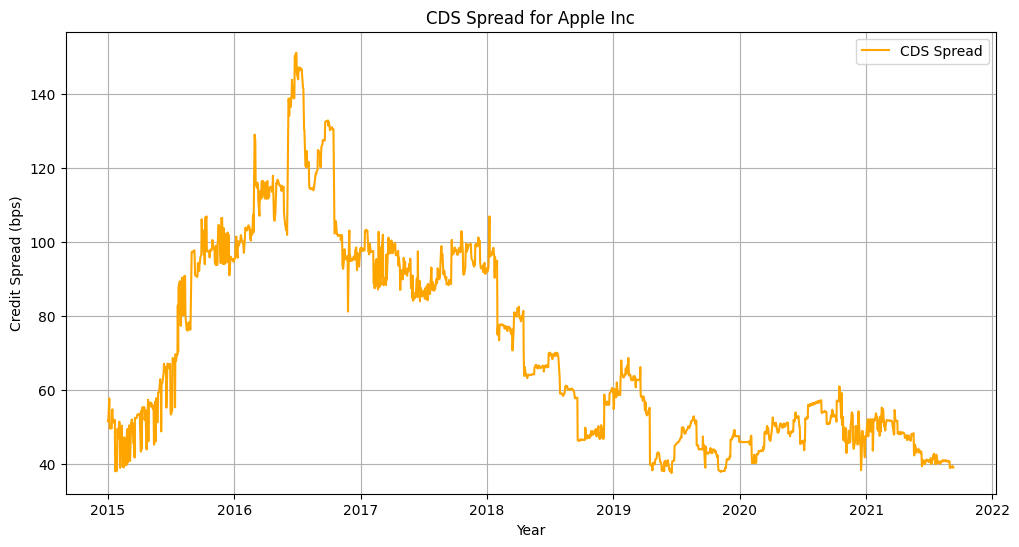

In [169]:
# Plot the time series of CDS spreads for Apple Inc
apple_cds = cds_data[cds_data['Company'] == 'Apple Inc']
apple_cds['Date'] = pd.to_datetime(apple_cds['Date'])
apple_cds.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(apple_cds.index, apple_cds['PX10'], label='CDS Spread', color='orange')
plt.title('CDS Spread for Apple Inc')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()



In [170]:
cds_apple = cds_data[cds_data['Company'] == 'Apple Inc'].copy()
cds_apple = cds_apple.drop(columns=['Ticker','Company'])
cds_apple = cds_apple.set_index('Date')
cds_apple1y = cds_apple['PX10']
cds_apple1y = cds_apple1y / 10000  # Convert bps to decimal
lambda_1y = cds_apple1y / (1 - R)  # Hazard rate estimation


In [171]:
pd_1y_daily = 1.0 - np.exp(-lambda_1y)
pd_1y_daily.index = pd.to_datetime(pd_1y_daily.index)
pd_1y_yearly = pd_1y_daily.groupby(pd_1y_daily.index.year).mean()
pd_TTC = pd_1y_yearly.mean()
print(f'Through-The-Cycle 1-Year PD for Apple Inc: {pd_TTC:.4%}')

Through-The-Cycle 1-Year PD for Apple Inc: 1.1587%


In [195]:
# Data preparation for climate data frame : Scenario SSP5 - 6.0

IPCC_CSV_PATH = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"

df_ssp_raw = pd.read_csv(IPCC_CSV_PATH)
df_ssp = df_ssp_raw[df_ssp_raw["Scenario"] == "SSP1 - 1.9"].copy()
df_ssp = df_ssp.set_index("Year")

In [196]:
# Interpolate climate data from 2005 to 2100 yearly
years = np.arange(2005, 2101)
df_ssp = df_ssp.reindex(years)
df_ssp.interpolate(method='linear', inplace=True)
df_ssp = df_ssp.reset_index().rename(columns={"index": "Year"})
df_ssp.head()

/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_25970/216790850.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_ssp.interpolate(method='linear', inplace=True)


,Year,Scenario,Crop demand,Energy crop demand,Livestock demand,Energy crop production,Non-energy crop production,Livestock production,Carbon price,Methane concentration,...,Carbon intensity of energy,Primary energy intensity,Final energy intensity,Final energy as a share of primary energy,final_energy_biomass,final_energy_coal,final_energy_solar,annotation,primary_energy_intensity,final_energy_intensity
0,2005,SSP1 - 1.9,3.389947e+09,NaN,238986475.6,31469668.70,3.417340e+09,2.389865e+08,0.0,1753.1600,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,Sustainability - Taking the Green Road,0.007996,0.005936
1,2006,NaN,3.467989e+09,NaN,243677329.9,36383540.82,3.496545e+09,2.436774e+08,0.0,1765.1008,...,0.258600,2.187365,1.617163,73.911847,39.146056,33.231732,0.037450,NaN,0.007875,0.005822
2,2007,NaN,3.546032e+09,NaN,248368184.2,41297412.94,3.575751e+09,2.483682e+08,0.0,1777.0416,...,0.257087,2.153667,1.585425,73.584401,40.298861,34.836964,0.058441,NaN,0.007753,0.005708
3,2008,NaN,3.624074e+09,NaN,253059038.5,46211285.06,3.654956e+09,2.530591e+08,0.0,1788.9824,...,0.255574,2.119968,1.553686,73.256955,41.451667,36.442196,0.079432,NaN,0.007632,0.005593
4,2009,NaN,3.702117e+09,NaN,257749892.8,51125157.18,3.734162e+09,2.577499e+08,0.0,1800.9232,...,0.254061,2.086270,1.521948,72.929509,42.604473,38.047428,0.100423,NaN,0.007511,0.005479


In [197]:
cols = ["Carbon price", "Temperature"]

df_ssp1_19 = df_ssp[["Year"] + cols].copy()


In [198]:
yield_ssp1 = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/yield_forecasting_ssp1.csv', index_col=0)

# Interpolate yield data from 2005 to 2100 yearly
yield_ssp1 = yield_ssp1.reindex(years)
yield_ssp1.interpolate(method='linear', inplace=True)
yield_ssp1 = yield_ssp1.reset_index().rename(columns={"index": "Year"})
yield_ssp1.head()

,Year,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
0,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
df_ssp1_19['yield'] = yield_ssp1['10.0']

In [200]:
#Set Year as index
df_ssp1_19 = df_ssp1_19.set_index('Year')

In [201]:
#Standardize the variables
df_ssp1_19['z_yield'] = (df_ssp1_19['yield'] - df_ssp1_19['yield'].mean()) / df_ssp1_19['yield'].std()
df_ssp1_19['z_Carbon_Price'] = (df_ssp1_19['Carbon price'] - df_ssp1_19['Carbon price'].mean()) / df_ssp1_19['Carbon price'].std()
df_ssp1_19['z_Temperature'] = (df_ssp1_19['Temperature'] - df_ssp1_19['Temperature'].mean()) / df_ssp1_19['Temperature'].std()



In [202]:
df_ssp1_19 = df_ssp1_19.drop(columns=['yield','Carbon price','Temperature'])

In [203]:
df_ssp1_19 = df_ssp1_19.dropna()

In [204]:
rho = df_ssp1_19.corr()

In [205]:
beta_macro_sensitive = np.array([0.30, 0.15, 0.10])
a_apple = norm.ppf(pd_TTC)

In [206]:
# Estimate the conditional pd using SSP 1.9 scenario
pd_conditional = norm.cdf((a_apple - df_ssp1_19.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
lambda_conditional = -np.log(1 - pd_conditional) # Convert PD to hazard rate for 1 year
spread_conditional = lambda_conditional * (1 - R) * 10000  # Convert to bps

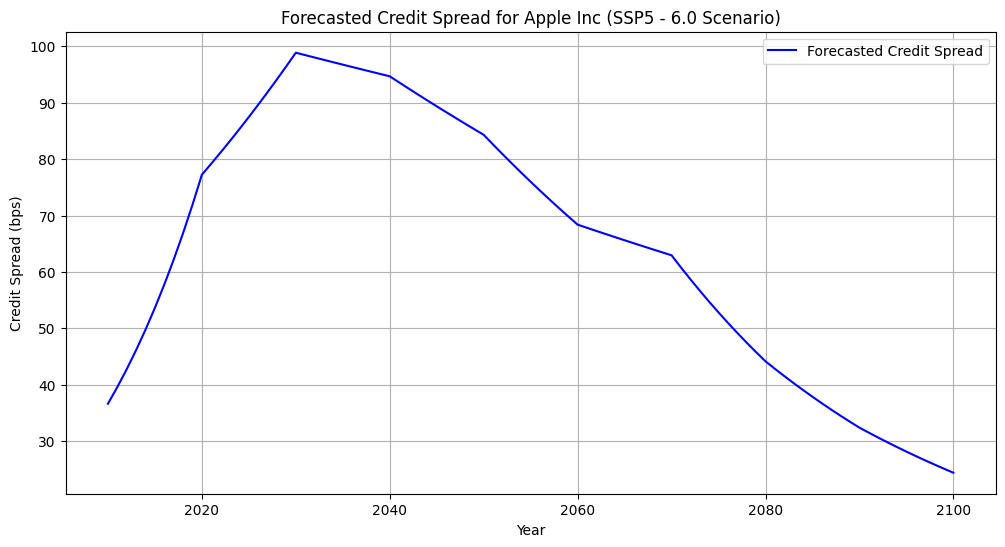

In [207]:
# Plot Credit Spread Forecasted
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, spread_conditional, label='Forecasted Credit Spread', color='blue')
plt.title('Forecasted Credit Spread for Apple Inc (SSP5 - 6.0 Scenario)')
plt.xlabel('Year')
plt.ylabel('Credit Spread (bps)')
plt.legend()
plt.grid()
plt.show()

In [208]:
# Add spread to yield curve
df_ssp1_19['Credit Spread'] = spread_conditional
yield_ssp1 = yield_ssp1.set_index('Year')
df_ssp1_19['Yield with CS'] = yield_ssp1['1.0'] + df_ssp1_19['Credit Spread']/10000
df_ssp1_19['Yield wo CS'] = yield_ssp1['1.0'] 


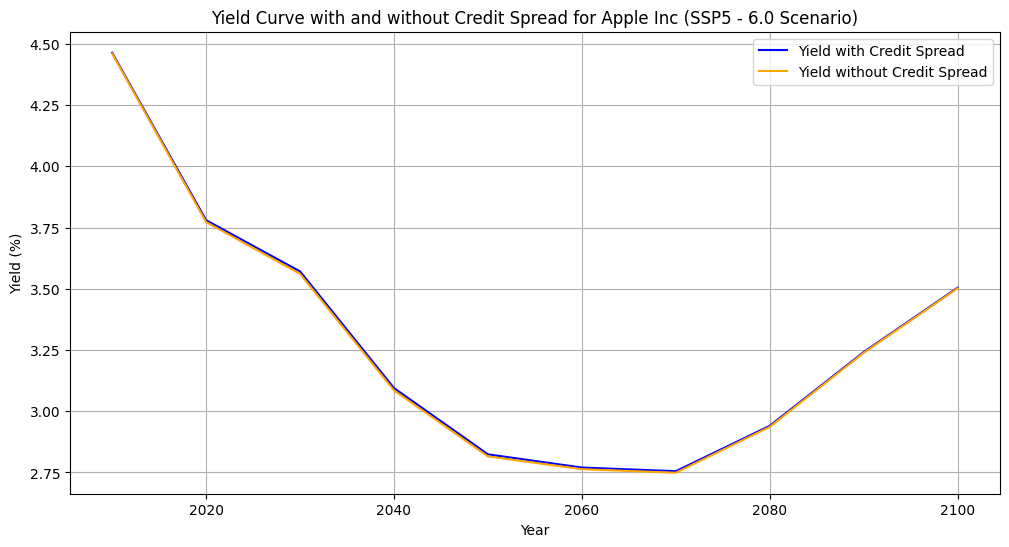

In [209]:
# Plort the yield curve with credit spread vs without credit spread
plt.figure(figsize=(12, 6))
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield with CS'], label='Yield with Credit Spread', color='blue')
plt.plot(df_ssp1_19.index, df_ssp1_19['Yield wo CS'], label='Yield without Credit Spread', color='orange')
plt.title('Yield Curve with and without Credit Spread for Apple Inc (SSP5 - 6.0 Scenario)')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

In [210]:
# Let's try to fit a copula to fit climate variables in order to generate scenarios
df_ssp1_19_copula = df_ssp1_19[['z_yield', 'z_Carbon_Price', 'z_Temperature']]

model = GaussianMultivariate()
model.fit(df_ssp1_19_copula)

samples = model.sample(1000)


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [211]:
#Trying t-student copula 
# Source - https://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/303eb11b4d617b79c1257b0800744575/$FILE/t%20copula%20demarta%20mcneil.pdf

from scipy.stats import invgamma, chi2, t

#Define number of sampling points
n_samples = 10000
df = 8

mu = np.zeros(len(rho))

s = chi2.rvs(df, size=n_samples)[:, np.newaxis]
#s = invgamma.pdf(df/2,df/2) 
Z = np.random.multivariate_normal(mu, rho,n_samples)
X = np.sqrt(df/s)*Z #chi-square method
#X = np.sqrt(s)*Z #inverse gamma method

U = t.cdf(X,df)


U_df = pd.DataFrame(U)
U_df.columns = ['z_yield', 'z_Carbon_Price', 'z_Temperature']
corr_simulated_tstudent = U_df.corr()


In [221]:
def empirical_inverse_cdf(data):
    # Build empirical CDF
    sorted_data = np.sort(data)
    def inv_cdf(u):
        idx = (u * (len(sorted_data)-1)).astype(int)
        return sorted_data[idx]
    return inv_cdf


inv_yield = empirical_inverse_cdf(df_ssp1_19_copula['z_yield'])
inv_carbon = empirical_inverse_cdf(df_ssp1_19_copula['z_Carbon_Price'])
inv_temp = empirical_inverse_cdf(df_ssp1_19_copula['z_Temperature'])

sim_yield = inv_yield(U_df['z_yield'].values)
sim_carbon = inv_carbon(U_df['z_Carbon_Price'].values)
sim_temp = inv_temp(U_df['z_Temperature'].values)

plot_df = pd.DataFrame({
    'z_yield': sim_yield,
    'z_Carbon_Price': sim_carbon,
    'z_Temperature': sim_temp
})



<Figure size 1450x1050 with 0 Axes>

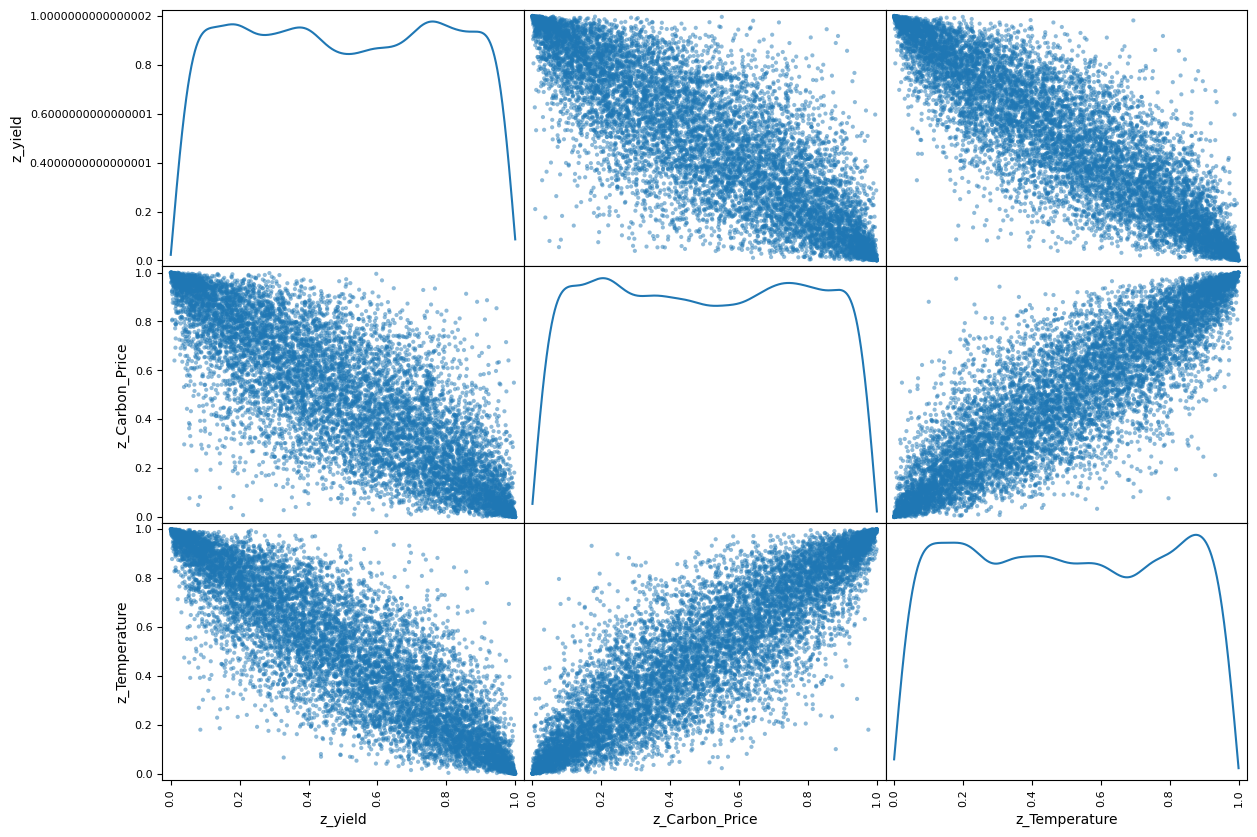

In [212]:
# Source - https://stackoverflow.com/q
# Posted by rhonsprudel, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-09, License - CC BY-SA 4.0

fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)
pd.plotting.scatter_matrix(U_df, figsize=(14,10), diagonal = 'kde')
plt.show()


In [213]:
# Let's compare the correlation matrix of the original data vs the simulated data
corr_original = df_ssp1_19_copula.corr()
corr_simulated = samples.corr()
print("Original Correlation Matrix:\n", corr_original)
print("Simulated Correlation Matrix:\n", corr_simulated)
print("Simulated Correlation Matrix t-Student:\n", corr_simulated_tstudent)

Original Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.835947      -0.891055
z_Carbon_Price -0.835947        1.000000       0.893738
z_Temperature  -0.891055        0.893738       1.000000
Simulated Correlation Matrix:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.615788      -0.840127
z_Carbon_Price -0.615788        1.000000       0.779725
z_Temperature  -0.840127        0.779725       1.000000
Simulated Correlation Matrix t-Student:
                  z_yield  z_Carbon_Price  z_Temperature
z_yield         1.000000       -0.823715      -0.879503
z_Carbon_Price -0.823715        1.000000       0.884097
z_Temperature  -0.879503        0.884097       1.000000


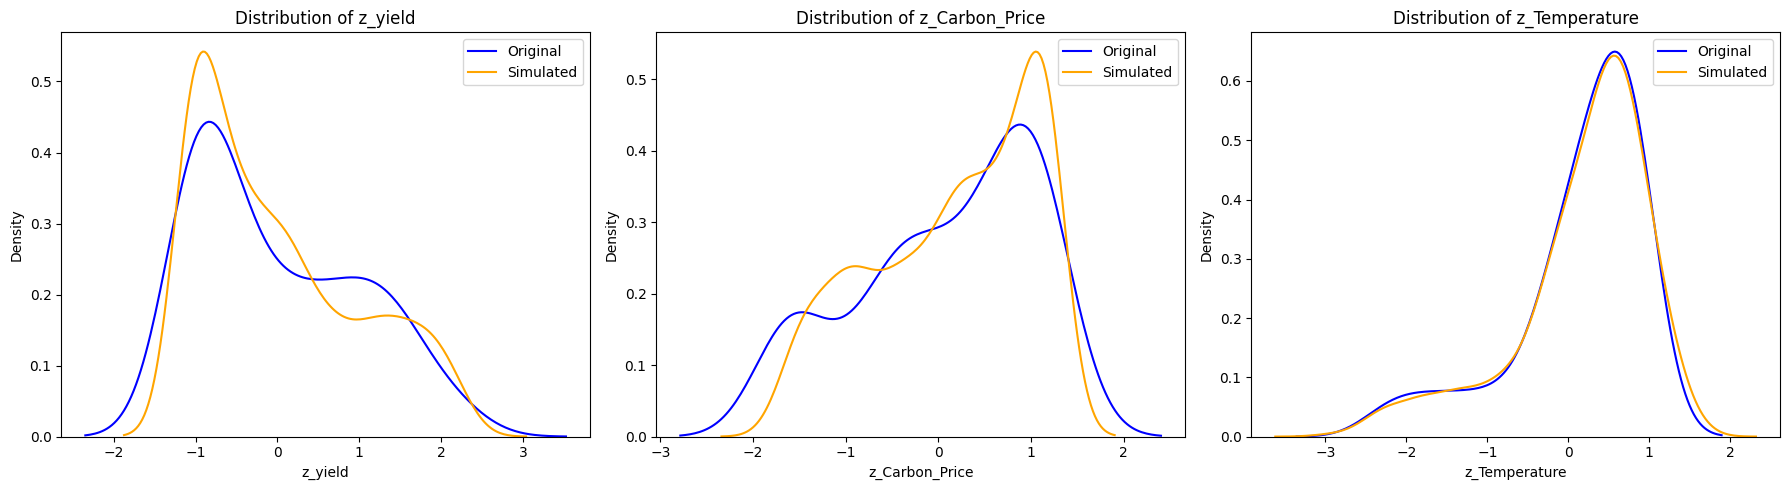

In [ ]:
#Let's plot the distributions of the original vs simulated data (Gaussian Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(samples[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

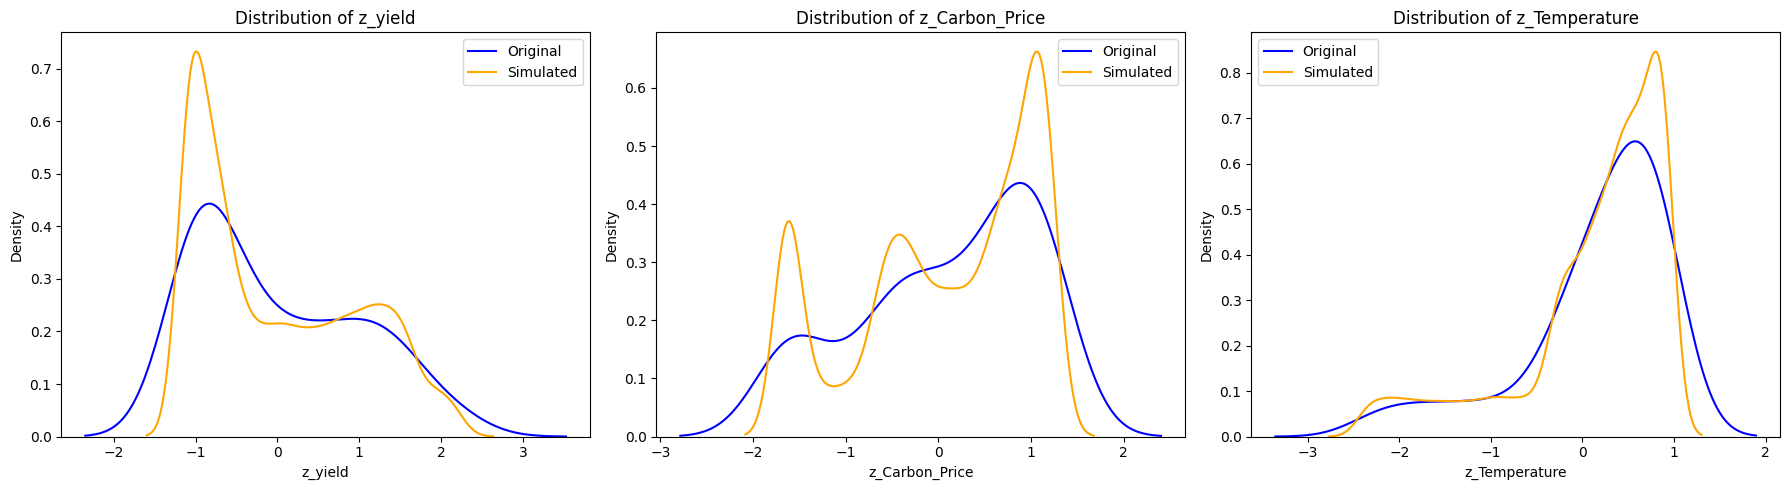

In [222]:
#Let's plot the distributions of the original vs simulated data (Gaussian Copula)
import seaborn as sns
plt.figure(figsize=(18, 5))
for i, col in enumerate(df_ssp1_19_copula.columns):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df_ssp1_19_copula[col], label='Original', color='blue')
    sns.kdeplot(plot_df[col], label='Simulated', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()  

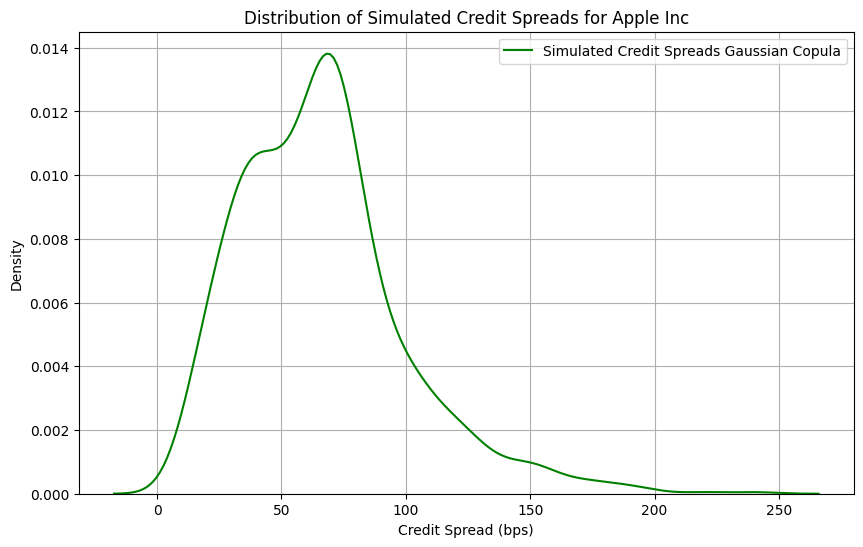

In [216]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (Gaussian Copula)
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a_apple - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads = []
for i in range(samples.shape[0]):
    simulated_row = samples.iloc[i]
    pd_conditional_sim = norm.cdf((a_apple - simulated_row.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim = -np.log(1 - pd_conditional_sim) # Convert PD to hazard rate for 1 year
    spread_conditional_sim = lambda_conditional_sim * (1 - R) * 10000  # Convert to bps
    simulated_spreads.append(spread_conditional_sim)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads, label='Simulated Credit Spreads Gaussian Copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Apple Inc')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  




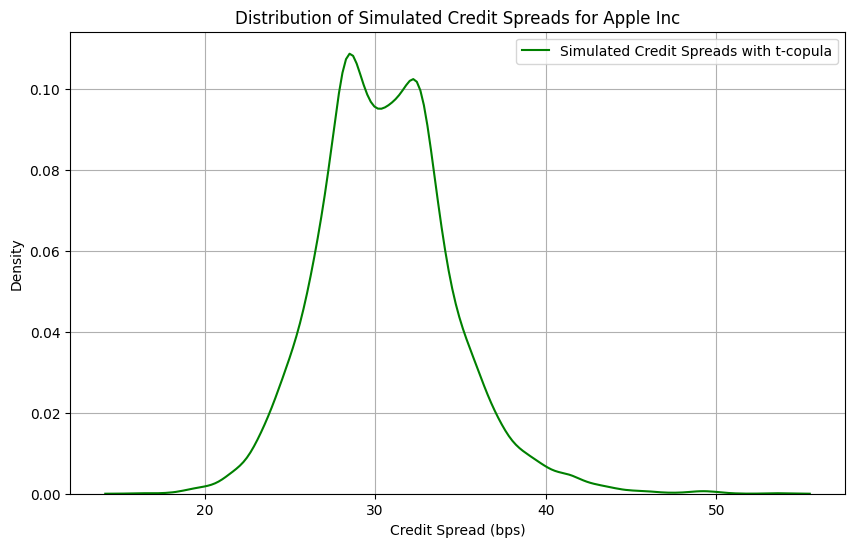

In [217]:
# Now we can use the simulated data to estimate credit spreads under different scenarios (t-Student Copula)
for i in range(samples.shape[0]):
    simulated_row_t = U_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a_apple - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) 
    # Here you can store or process the spread_conditional_sim as needed


# Plot the distribution of the simulated credit spreads
simulated_spreads_t = []
for i in range(U_df.shape[0]):
    simulated_row_t = U_df.iloc[i]
    pd_conditional_sim_t = norm.cdf((a_apple - simulated_row_t.values @ beta_macro_sensitive.T)/np.sqrt(1 - beta_macro_sensitive.T @ rho @ beta_macro_sensitive))
    lambda_conditional_sim_t = -np.log(1 - pd_conditional_sim_t) # Convert PD to hazard rate for 1 year
    spread_conditional_sim_t = lambda_conditional_sim_t * (1 - R) * 10000  # Convert to bps
    simulated_spreads_t.append(spread_conditional_sim_t)
plt.figure(figsize=(10, 6))
sns.kdeplot(simulated_spreads_t, label='Simulated Credit Spreads with t-copula', color='green')
plt.title('Distribution of Simulated Credit Spreads for Apple Inc')
plt.xlabel('Credit Spread (bps)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()  


